# Modeling

## Model1 : Collaborative Filtering with Surprise SVD
Collaborative filtering is to discover the similarities on the user’s past behavior and make predictions to the user based on a similar preference with other users. This model is then used to predict items (or ratings for items) that the user may have an interest in.


#### Load the packages

In [39]:
#standard packages
%matplotlib inline
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

# Surprise modules
from surprise import SVD
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise import Dataset, Reader
from surprise import accuracy
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV

In [40]:
# Load the data
product_info = pd.read_csv('../data/raw/archive/product_info.csv')
reviews250 = pd.read_csv('../data/raw/archive/reviews_0_250.csv', low_memory=False, index_col=0)
reviews500 = pd.read_csv('../data/raw/archive/reviews_250_500.csv', low_memory=False, index_col=0)
reviews750 = pd.read_csv('../data/raw/archive/reviews_500_750.csv', low_memory=False, index_col=0)
reviews1000 = pd.read_csv('../data/raw/archive/reviews_750_1000.csv', low_memory=False, index_col=0)
reviews1500 = pd.read_csv('../data/raw/archive/reviews_1000_1500.csv', low_memory=False, index_col=0)
reviewsend = pd.read_csv('../data/raw/archive/reviews_1500_end.csv', low_memory=False, index_col=0)

In [48]:
df = pd.concat([reviews250, reviews500, reviews750, reviews1000, reviews1500, reviewsend])
df.rename(columns = {'author_id':'user_id', 'product_id':'item_id'}, inplace=True)
df = df[['user_id', 'item_id', 'rating']]
df.dropna(axis = 0, how = 'any', inplace = True)    
# All item ids are unique in the dataset
print(df.shape)
df = df.drop_duplicates(subset = ['user_id', 'item_id'])
print(df.shape)

(1301136, 3)
(1088886, 3)


### Model fitting

In [49]:
# Assume you have a pandas DataFrame df with columns 'user', 'item', 'rating'
reader = Reader(rating_scale=(1, 5))  
data = Dataset.load_from_df(df, reader)

In [50]:
# Split data into train and test
trainset, testset = train_test_split(data, test_size=0.2)

In [51]:
# Instantiate SVD and fit the trainset
algo = SVD()
algo.fit(trainset)

### Model Evaluation

We use different evaluation metrics to understand how well  model is performing. 

Metrics used:  Root Mean Square Error (RMSE), Mean Absolute Error (MAE), precision, recall, F1 score, and Area Under the ROC Curve (AUC-ROC).

In [52]:
predictions = algo.test(testset)

# Then compute RMSE and MAE
accuracy.rmse(predictions)
accuracy.mae(predictions)

# For precision and recall we need to define a threshold for positive vs. negative ratings
# Here we'll use 3.5 (on a 5-point scale), but this will depend on how your ratings are distributed
threshold = 3.5
true_positives = sum([1 for prediction in predictions if prediction.r_ui >= threshold and prediction.est >= threshold])
true_negatives = sum([1 for prediction in predictions if prediction.r_ui < threshold and prediction.est < threshold])
false_positives = sum([1 for prediction in predictions if prediction.r_ui < threshold and prediction.est >= threshold])
false_negatives = sum([1 for prediction in predictions if prediction.r_ui >= threshold and prediction.est < threshold])

# Compute precision, recall, and F1 score
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
f1 = 2 * (precision * recall) / (precision + recall)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1: {f1:.2f}")



RMSE: 1.0287
MAE:  0.7566
Precision: 0.85
Recall: 0.98
F1: 0.91


### Classification metrics
We also binarize the ratings into 'good' and 'bad' to produce classification metrics 

In [ ]:
# Binarize the ratings in testset
testset_binarized = [1 if rating >= 4 else 0 for (_, _, rating) in testset]

# Predict ratings for the testset
preds = [pred.est for pred in predictions]

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(testset_binarized, preds)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Cross-validation

We implement cross-validation to get a more robust estimate of model's performance. 

In [34]:
# Run 5-fold cross-validation and print results
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0341  1.0326  1.0333  1.0303  1.0262  1.0313  0.0028  
MAE (testset)     0.7602  0.7593  0.7581  0.7582  0.7550  0.7582  0.0018  
Fit time          8.34    9.82    8.53    8.54    9.05    8.86    0.54    
Test time         4.03    2.54    0.91    1.03    0.94    1.89    1.23    


{'test_rmse': array([1.03407334, 1.03259883, 1.03333561, 1.03030181, 1.02620245]),
 'test_mae': array([0.760241  , 0.75928813, 0.75813547, 0.75821863, 0.75500364]),
 'fit_time': (8.340489864349365,
  9.821595191955566,
  8.53267788887024,
  8.54078221321106,
  9.054226875305176),
 'test_time': (4.0313379764556885,
  2.5376667976379395,
  0.9078688621520996,
  1.029163122177124,
  0.9350221157073975)}

In [ ]:
### Hyperparameter tuning

In [ ]:
# Define the parameter grid
param_grid = {
    'lr_all': [0.002, 0.005, 0.01],  # learning rates
    'reg_all': [0.2, 0.4, 0.6]  # regularization terms
}

# Use the SVD algorithm
algo = SVD

# Run a grid search with cross-validation
gs = GridSearchCV(algo, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)

# Get the best parameters
print(gs.best_params['rmse'])

### Using predictions to produce recommendations

In [ ]:
# Predictions can now be made with the predict() method
# For example, predicting the rating of the item with id 'item_id' for the user with id 'user_id'
user_id = '6538326896'
item_id = 'P480354'
prediction = algo.predict(user_id, item_id)
print(prediction.est)

# Assume user_ids and item_ids are arrays or lists of user ids and item ids.
user_ids = ['7446977307', '1991973234', '42434587408']
item_ids = ['P467602', 'P481993', 'P481993']

# Assuming 'algo' is your trained model
predictions = [algo.predict(user_id, item_id) for user_id, item_id in zip(user_ids, item_ids)]

# Extract the estimated ratings
estimated_ratings = [pred.est for pred in predictions]

In [ ]:
user_id = '6538326896'  # replace with actual user id
item_ids = df['item_id'].unique()
preds = [algo.predict(user_id, item_id) for item_id in item_ids]
preds_df = pd.DataFrame([(pred.uid, pred.iid, pred.est) for pred in preds], columns=['user_id', 'item_id', 'rating'])

n_recommendations = 5
top_n_recs = preds_df[preds_df['user_id'] == user_id].nlargest(n_recommendations, 'rating')
print(top_n_recs)

### Provide top 10 recommendations to a user

In [70]:

def recommend_unreviewed_items(user_id, model, df, n_recommendations=10):
    # Get the item IDs that the user has already rated
    rated_item_ids = df[df['user_id'] == user_id]['item_id']

    # Get all item IDs
    all_item_ids = df['item_id'].unique()

    # Get the item IDs that the user hasn't rated yet
    unrated_item_ids = np.setdiff1d(all_item_ids, rated_item_ids)

    # Make predictions for the unrated items only
    preds = [model.predict(user_id, item_id) for item_id in unrated_item_ids]

    # Convert predictions to DataFrame
    preds_df = pd.DataFrame([(pred.uid, pred.iid, pred.est) for pred in preds], columns=['user_id', 'item_id', 'rating'])

    # Get top N recommendations
    top_n_recs = preds_df.nlargest(n_recommendations, 'rating')

    return top_n_recs



In [76]:
# Example usage:
user_id = '6538326896'  # replace with actual user id
#print(recommend_unreviewed_items(user_id, algo, df))

print('For user ', user_id, ' we recommend items: ' , recommend_unreviewed_items(user_id, algo, df).item_id.tolist())

For user  6538326896  we recommend items:  ['P4010', 'P471788', 'P460516', 'P188309', 'P419466', 'P470247', 'P122718', 'P426340', 'P465803', 'P459128']


Through our exploration, we employed multiple machine learning methods, including SVD, NMF, KNN, and hybrid models like LightFM. SVD and LightFM (with both item and user features) showed promising results. Despite some challenges related to data sparsity and computational requirements, the models performed reasonably well.

### Additional work to explore other models

### Show which items were rated by user given user_id

In [63]:
def rated_items(user_id, df):
    # Get the items rated by the user
    rated_df = df[df['user_id'] == user_id]

    return rated_df

# Example usage:
user_id = '47056667835'  # replace with actual user id
print(rated_items(user_id, df))


            user_id  item_id  rating
4       47056667835  P420652       5
184800  47056667835  P443563       5


### See how many ratings each user gave

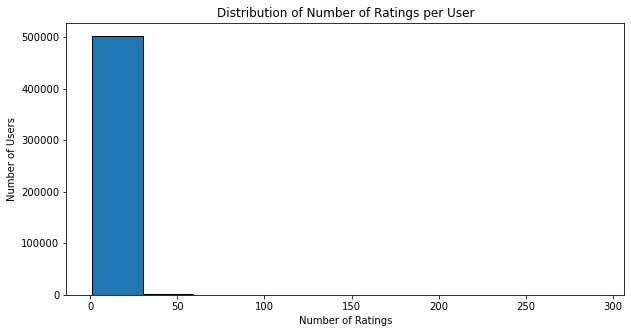

In [80]:
# Count the number of ratings each user has made
ratings_count = df.groupby('user_id')['rating'].count()

# Convert the Series to a DataFrame
ratings_count_df = ratings_count.reset_index()

# Rename the columns
ratings_count_df.columns = ['user_id', 'num_ratings']

# Show the DataFrame
#print(ratings_count_df)
plt.figure(figsize=(10,5))
plt.hist(ratings_count_df['num_ratings'], bins=10, edgecolor='black')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.title('Distribution of Number of Ratings per User')
plt.show()


### Exploring additional methods
Other common collaborative filtering algoriths include KNN, NMf and Biased SVD.

### Note on KNN
KNN algorithm is a simple and commonly used method for making recommendations, but it can struggle with large datasets due to its computational complexity.
KNN works by computing distances between items or users, which requires comparing each item (or user) to every other item (or user). As a result, the time and space complexity of the algorithm is quadratic in the number of items or users. This means that as the dataset grows, the time and memory required to run KNN increase rapidly.

For a dataset with 1,088,886 ratings of unique users and items, KNN was too slow and required a large amount of memory, so we consider using a more scalable algorithm.


### Model 2: NMF

In this code, we are using the default hyperparameters for the NMF algorithm, which are:

n_factors: The number of factors. Default is 15.
n_epochs: The number of iteration of the SGD procedure. Default is 50.
biased: Whether to use baselines (or biases). Default is True.

In [19]:
from surprise import NMF, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split

algo2 = NMF()
algo2.fit(trainset)
predictions = algo2.test(testset)

# Then compute RMSE
print("RMSE: ", accuracy.rmse(predictions))

# compute MAE
print("MAE: ", accuracy.mae(predictions))


RMSE: 1.0019
RMSE:  1.0019127397679086
MAE:  0.6839
MAE:  0.6838654487444777


In [21]:
# Run 5-fold cross-validation and print results
cross_validate(algo2, data, measures=['RMSE', 'MAE'], cv=2, verbose=True)

Evaluating RMSE, MAE of algorithm NMF on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    1.0998  1.1003  1.1001  0.0002  
MAE (testset)     0.7892  0.7896  0.7894  0.0002  
Fit time          23.01   23.87   23.44   0.43    
Test time         9.16    4.93    7.04    2.12    


{'test_rmse': array([1.09982652, 1.10030994]),
 'test_mae': array([0.78924875, 0.7895833 ]),
 'fit_time': (23.012303113937378, 23.867035150527954),
 'test_time': (9.161565065383911, 4.926636695861816)}

Well it looks like the Mean RMSE is 1.10 and MAE is 0.79 while SVD had 0.91, 0.64 RMSE and MAE correspondingly. 
So SVD seems to do better.

### Model 3: Biased SVD

In [23]:
# Use the biased SVD algorithm
algo3 = SVD(biased = True) # default is True

In [24]:
# Run 5-fold cross-validation and print results
cross_validate(algo3, data, measures = ['RMSE', 'MAE'], cv = 5, verbose = True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9170  0.9170  0.9155  0.9149  0.9199  0.9169  0.0017  
MAE (testset)     0.6465  0.6466  0.6451  0.6455  0.6481  0.6464  0.0011  
Fit time          10.25   10.11   10.39   10.37   10.11   10.24   0.12    
Test time         1.17    1.22    1.22    1.15    1.22    1.20    0.03    


{'test_rmse': array([0.91697627, 0.91695062, 0.91548728, 0.91490322, 0.91993438]),
 'test_mae': array([0.64653607, 0.64657084, 0.64509574, 0.64550031, 0.64814452]),
 'fit_time': (10.2471342086792,
  10.109180927276611,
  10.387124061584473,
  10.371218919754028,
  10.107017278671265),
 'test_time': (1.1713521480560303,
  1.2228519916534424,
  1.2185652256011963,
  1.1538362503051758,
  1.2164320945739746)}

Well, it looks like Biased SVD doesn't perform much better, so we prefer the parsimonious model: Regular SVD.